In [1]:
%load_ext autoreload
%autoreload 2

# Multi-Task BO NIPS Paper

This is a paper for the [ML4Molecules workshop](https://ml4molecules.github.io/) at NIPS 2020.

In [2]:
from summit.strategies import STBO, MTBO, Transform, LHS, Chimera
from summit.benchmarks import (
    MIT_case1,
    MIT_case2,MIT_case3,
    MIT_case4,
    MIT_case5,
    BaumgartnerCrossCouplingEmulator,
    ExperimentalEmulator
)
from summit.utils.dataset import DataSet
from summit.domain import *
import summit
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from IPython.display import clear_output
from copy import deepcopy

In [20]:
def run_stbo(exp, max_iterations=10, categorical_method="one-hot"):
    exp.reset()
    strategy = STBO(exp.domain, 
                    categorical_method=categorical_method)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_mtbo(exp, pt_data, max_iterations=10):
    strategy = MTBO(exp.domain, 
                    pretraining_data=pt_data,
                    categorical_method="one-hot", 
                    task=1)
    r = summit.Runner(strategy=strategy,
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def make_average_plot(results: List[summit.Runner], ax, label=None, color=None):
    objective = results[0].experiment.domain.output_variables[0].name
    yields = [r.experiment.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1)

def make_comparison_plot(*args):
    fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg.get("color"))
    fontdict = fontdict={"size":12}
    ax.legend(loc = "lower right", prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
    ax.set_ylabel('Yield', fontdict=fontdict)
    ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return fig, ax

In [4]:
N_REPEATS = 10
MAX_ITERATIONS = 20

## Kinetic Models

![](figures/baumgartner_mechanisms.png)

We will use MIT case 1 as the auxiliary task for pretraining.

In [6]:
exp_pt = MIT_case1(noise_level=1)
exp_pt.domain

Name,Type,Description,Values
conc_cat,"continuous, input",catalyst concentration,"[0.000835,0.004175]"
t,"continuous, input",reaction time,"[60,600]"
cat_index,"categorical, input",Choice of catalyst,8 levels
temperature,"continuous, input",Reactor temperature in degress celsius,"[30,110]"
y,"continuous, maximize objective",yield (%),"[0,100]"


We first generate different amounts of data using latin hypercube sampling.

Now, we can run single-task and multi-task Bayesian optimization.

In [8]:
def generate_mit_case_1_data(n_points):
    exp_pt = MIT_case1(noise_level=1)
    rs = np.random.RandomState(100)
    lhs = LHS(exp_pt.domain, random_state=rs)
    conditions = lhs.suggest_experiments(n_points)
    exp_pt.run_experiments(conditions)
    pt_data = exp_pt.data
    pt_data['task', 'METADATA'] = 0
    return pt_data

n_aux = [5, 10, 50]
aux_datasets = [generate_mit_case_1_data(n) for n in n_aux]

### Same Mechanism

In [ ]:
#Single-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case2(noise_level=1)
    result = run_stbo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"data/kinetics_similar/stbo_case1-2_noise_repeat_{i}.json")
    clear_output(wait=True)

In [23]:
#Multi-Task Bayesian Optimization
for n, dataset in zip(n_aux, aux_datasets):
    for i in range(N_REPEATS):
        print(f"Repeat {i}")
        exp = MIT_case2(noise_level=1)
        result = run_mtbo(exp, dataset, max_iterations=MAX_ITERATIONS)
        result.save(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json")
        clear_output(wait=True)

Repeat 9


Finally, we can make a plot for the paper.

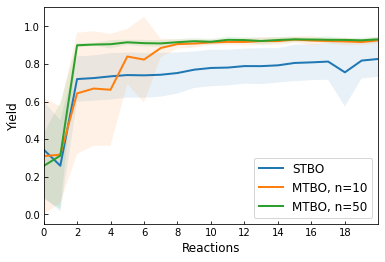

In [40]:
stbo_results = [summit.Runner.load(f"data/kinetics_similar/stbo_case1-2_noise_repeat_{i}.json") for i in range(10)]
mtbo_results_lists = [[summit.Runner.load(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json") 
                      for i in range(10)]
                      for n in n_aux]
fig, ax = make_comparison_plot(
    dict(results=stbo_results, label="STBO"),
#     dict(results=mtbo_results_lists[0],label="MTBO, n=5"),
    dict(results=mtbo_results_lists[1],label="MTBO, n=10"),
    dict(results=mtbo_results_lists[2],label="MTBO, n=50")
)
fig.savefig("figures/stbo_mtbo_kinetics_case1-2_noise_comparison.png", bbox_inches='tight', dpi=300)

### Different Mechanisms

This adds an extra wrinkle because there is a competing reaction which consumes B (see Case 3 from figure above).

In [32]:
#Single-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case3(noise_level=1)
    result = run_stbo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"data/kinetics_different/stbo_case1-3_noise_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


In [13]:
#Multi-Task Bayesian Optimization
j = 2
pt_data = aux_datasets[j]
n=n_aux[j]
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case3(noise_level=1)
    result = run_mtbo(exp, pt_data, max_iterations=MAX_ITERATIONS)
    result.save(f"data/kinetics_different/mtbo_case1-3_noise_{n}-pre-train_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


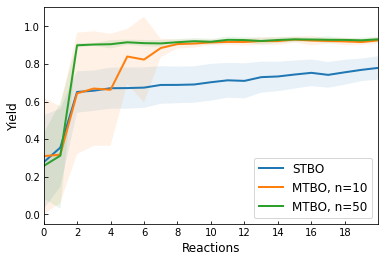

In [47]:
stbo_results = [summit.Runner.load(f"data/kinetics_different/stbo_case1-3_noise_repeat_{i}.json") 
                for i in range(10)]
mtbo_results_lists = [[summit.Runner.load(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json") 
                      for i in range(10)]
                      for n in [10,50]]
fig, ax = make_comparison_plot(
    dict(results=stbo_results, label="STBO"),
    dict(results=mtbo_results_lists[0],label="MTBO, n=10"),
    dict(results=mtbo_results_lists[1],label="MTBO, n=50")
)
fig.savefig("figures/stbo_mtbo_kinetics_case1-3_noise_comparison.png", bbox_inches='tight', dpi=300)

## C-N Cross Couplings

First we need to get the data from the Baumgartner paper and do some manipulation to get it in the form we want

In [5]:
b_df = pd.read_excel("data/baumgartner_data.xlsx", sheet_name="Reaction data")
# Just the columns we want
b_df = b_df[[
    "Optimization", 
    "Base",
    "Base equivalents",
    "Temperature (degC)",
    "Residence Time Actual (s)",
    "Reaction Yield"
]]
# Rename columns
columns =  {"Optimization": "catalyst", 
    "Base": "base",
    "Base equivalents": "base_equivalents",
    "Temperature (degC)": "temperature",
    "Residence Time Actual (s)": "t_res",
    "Reaction Yield": "yld"
}
b_df = b_df.rename(columns=columns)

# Drop preliminary reactions
b_df = b_df.iloc[:363,:] 
#Split catalyst column into nucleophile and catlyst
new = b_df["catalyst"].str.split(" - ", n=1, expand=True)
# Create new columns
b_df["nucleophile"] = new[0]
b_df["catalyst"] = new[1]
# Create a dtaset for each nucleophile
nucleophiles = pd.unique(b_df["nucleophile"])
dfs = {nucleophile: b_df[b_df["nucleophile"]==nucleophile]
       for nucleophile in nucleophiles}
datasets = {nucleophile: DataSet.from_df(dfs[nucleophile], metadata_columns="nucleophile")
            for nucleophile in nucleophiles}

### Differing Substrates

Optimize aniline case with auxiliary data from benzamide case.

In [6]:
#Single-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = BaumgartnerCrossCouplingEmulator()
    result = run_stbo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"data/cross_coupling/stbo_cn_noise_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


In [10]:
#Multi-Task Bayesian Optimization
pt_data = datasets["Benzamide"]
pt_data["task", "METADATA"] = 0
# Drop base=MTBD because not in other dataset
pt_data = pt_data[pt_data["base"] != "MTBD"]
# Clean data
pt_data = pt_data.replace("≥90%", 0.9)
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = BaumgartnerCrossCouplingEmulator()
    result = run_mtbo(exp, pt_data, max_iterations=MAX_ITERATIONS)
    result.save(f"data/cross_coupling/mtbo_cn_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


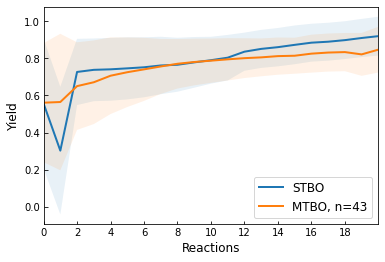

In [21]:
stbo_results = [summit.Runner.load(f"data/cross_coupling_different/stbo_cn_noise_repeat_{i}.json") 
                for i in range(10)]
mtbo_results = [summit.Runner.load(f"data/cross_coupling_different/mtbo_cn_repeat_{i}.json") 
                for i in range(10)]
fig, ax = make_comparison_plot(
    dict(results=stbo_results, label="STBO"),
    dict(results=mtbo_results,label="MTBO, n=43"),
)
fig.savefig("figures/stbo_mtbo_cn_different.png", bbox_inches='tight', dpi=300)

### Similar Substrates

What if our auxiliary data is similar to the task being optimized? In this case primary amine to secondary amine.

Since we don't have a benchmark for this, we first need to train a model.

In [6]:
#Create the domain based on Baumgartner, but with different bases
bases_primary = pd.unique(datasets["Phenethylamine"]["base"])
bases_secondary = pd.unique(datasets["Morpholine"]["base"])
assert bases_primary.all() == bases_secondary.all()
exp = BaumgartnerCrossCouplingEmulator()
new_domain = deepcopy(exp.domain)
bases = list(pd.unique(datasets["Morpholine"]["base"]))
new_domain["base"] = CategoricalVariable(name="base", description="Base", levels=bases)
new_domain

Name,Type,Description,Values
catalyst,"categorical, input",Catalyst type,3 levels
base,"categorical, input",Base,4 levels
base_equivalents,"continuous, input",Base equivalents,"[1.0,2.5]"
temperature,"continuous, input",Temperature in degrees Celsius (ºC),"[30,100]"
t_res,"continuous, input",residence time in seconds (s),"[60,1800]"
yld,"continuous, maximize objective",Yield,"[0.0,1.0]"


Do you want to overwrite this file? If yes, type 'y' or 'yes', else type 'n' or 'no':  y


Do you want to overwrite this file? If yes, type 'y' or 'yes', else type 'n' or 'no':  y


Evaluation based on training and test set.


({'yld': {'Train': {'MAE': 0.38840436935424805,
    'RMSE': 0.40859803557395935,
    'r2': -0.018294166047013727},
   'Test': {'MAE': 0.37007373571395874,
    'RMSE': 0.3907167613506317,
    'r2': -0.04729970682817819}}},
 [(<Figure size 432x288 with 1 Axes>,
   <AxesSubplot:xlabel='Experimental y', ylabel='Predicted y'>)])

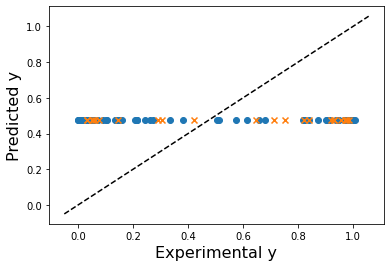

In [14]:
# Train primary amine benchmark model
exp_amine = ExperimentalEmulator(domain=new_domain, model_name="baumgartner_primary_amine")
training_ds = datasets["Phenethylamine"]
training_ds = training_ds.replace("≥90%", 0.9)
exp_amine.train(dataset=datasets["Phenethylamine"], cv_fold=2, test_size=0.25, verbose=False)
exp_amine.validate(parity_plots=True)

In [13]:
exp_amine.reset()
lhs = LHS(exp_amine.domain)
conditions = lhs.suggest_experiments(2)
exp_amine.run_experiments(conditions)

,catalyst,base,base_equivalents,temperature,t_res,yld,computation_t,experiment_t,strategy
0,tBuXPhos,BTTP,2.125,82.5,1365.0,0.463060,0.0,0.030719,LHS
1,AlPhos,MTBD,1.375,47.5,495.0,0.462861,0.0,0.034983,LHS


In [6]:
#Single-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    result = run_stbo(exp_amine, max_iterations=MAX_ITERATIONS)
    result.save(f"data/cross_coupling_similar/stbo_cn_noise_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


In [13]:
#Multi-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case3(noise_level=1)
    result = run_mtbo(exp_amine, pt_data, max_iterations=MAX_ITERATIONS)
    result.save(f"data/cross_coupling_similar/mtbo_case1-3_noise_{n}-pre-train_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


Name,Type,Description,Values
catalyst,"categorical, input",Catalyst type,3 levels
base,"categorical, input",Base,4 levels
base_equivalents,"continuous, input",Base equivalents,"[1.0,2.5]"
temperature,"continuous, input",Temperature in degrees Celsius (ºC),"[30,100]"
t_res,"continuous, input",residence time in seconds (s),"[60,1800]"
yld,"continuous, maximize objective",Yield,"[0.0,1.0]"
